In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from scipy.stats import shapiro, t, norm

In [2]:
df = pd.read_csv("US_Accidents_Dec19.csv")

In [3]:
#we take only a sample of the dataset to speed up computations
df = df.sample(100000, replace=False)

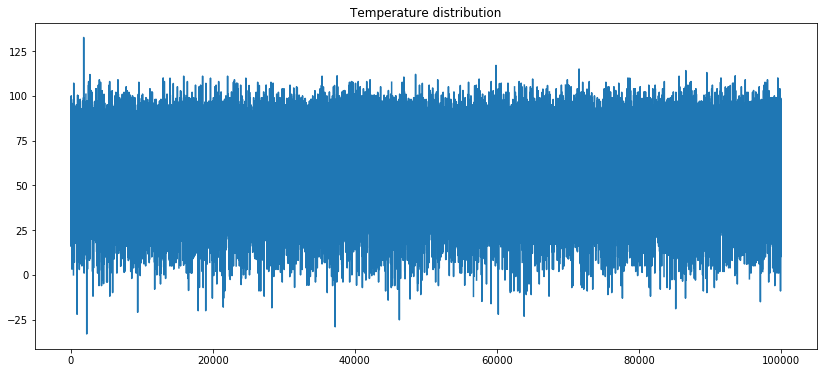

In [4]:
plt.figure(figsize=(14,6))
plt.title("Temperature distribution")
plt.plot(df["Temperature(F)"].values)
plt.show()

In [134]:
confidence=0.95

In [ ]:
alpha = 0.05
alpha_2 = 0.025

In [215]:
norm.ppf((1-confidence)/2, 2, 1)

0.04003601545994595

In [408]:
def plot_norm(confidence, mu=0, sigma=1):
    
    plt.figure(figsize=(16,5))
    plt.title("Normal distribution")
    
    alpha = 1 - confidence

    x = np.arange(-1, 1, 0.001)
        
    z_alpha2 = norm.ppf(alpha/2) 
    
    print(z_alpha2)
    cond = (x/sigma<z_alpha2) | (x/sigma>abs(z_alpha2))

    plt.fill_between(x+mu, norm.pdf(x, 0, sigma), where=~cond, 
                     label=f"{round(confidence,4)}")
    plt.fill_between(x+mu, norm.pdf(x, 0, sigma), where=cond, 
                     label=f"{round(alpha,4)}")
    
    plt.legend(title="AUC")
    plt.show()

In [410]:
def funz(sample_size, col_name, confidence=0.95):
    
    column = df[col_name]
    
    sample = column.sample(sample_size, replace=False)
    
    m = sample.mean()
    
    s = sample.std()/np.sqrt(sample_size)
    
    h = s * t.ppf((1 + confidence) / 2, sample_size - 1)
    h2 = s * norm.ppf((1 + confidence) / 2)
    
    print(f"t-confidence_interval: [{round(m-h,4)}, {round(m+h,4)}]")
    print(f"z-confidence_interval: [{round(m-h2,4)}, {round(m+h2,4)}]")
        
    plot_norm(confidence, mu=m, sigma=s)  

In [386]:
#df["Temperature(F)"].mean()

-1.959963984540054


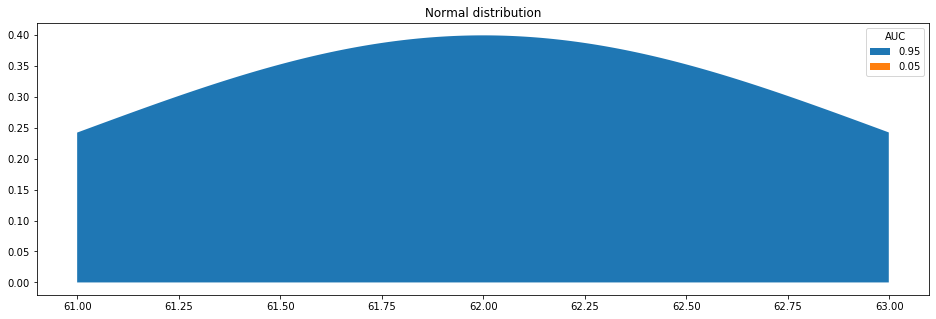

In [400]:
plot_norm(0.95, mu=62, sigma=1)

t-confidence_interval: [61.6855, 63.3007]
z-confidence_interval: [61.686, 63.3002]
t-confidence_interval: [-1.9612, 1.9612]
z-confidence_interval: [-1.96, 1.96]
-1.959963984540054


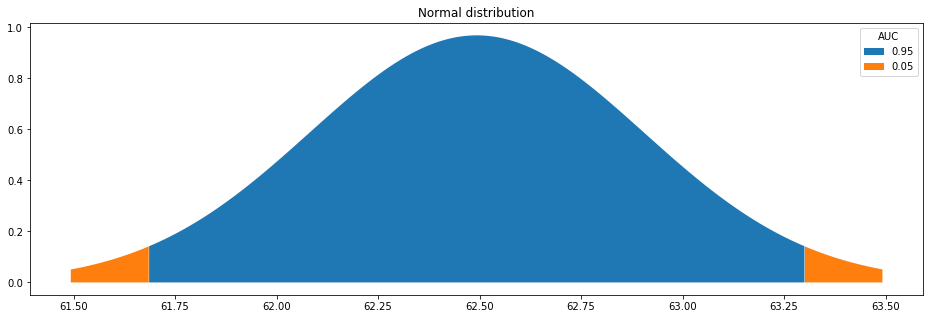

In [411]:
funz(2000, "Temperature(F)", confidence=0.95)

In [61]:
def extract_mean(iterations, sample_size, col_name, plot=False):
    
    means = []
    column = df[col_name]
    
#     print("Population mean: ", column.mean())
#     print("Population standard deviation: ", column.std())
#     print("sigma/sqrt(n): ", column.std()/np.sqrt(sample_size))
    
    for i in range(iterations):
#         if i % 50 == 0:
#             print(i)
        
        sample = column.sample(sample_size, replace=False)
    
        means.append(sample.mean())
    
#     print("Sampling distribution mean: ", np.mean(means))
#     print("Sampling distribution standard deviation: ", np.std(means, ddof=0))
    
#     print("diff: ", abs(column.std()/np.sqrt(sample_size)-np.std(means, ddof=0)))
    
#     print("\n")
    
    if plot == True:
#         stat, p = shapiro(means)
#         print('Statistics={}, p={}'.format(stat, p))
#         alpha = 0.05
#         if p > alpha:
#             print('Sample looks Normal (do not reject H0)')
#         else:
#             print('Sample does not look Normal (reject H0)')


        plt.figure(figsize=(14,6))
        plt.title(f"Sample mean distribution, {iterations} extractions, each" 
                  f" with sample size = {sample_size}")
        sns.distplot(means, hist=True, kde=True, bins=30, color = 'darkblue', 
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 4})

        plt.axvline(np.mean(means), color="red", label="distribution mean")
        plt.axvline(column.mean(), color="green", label="population mean")
        plt.legend()
        plt.show()
    
    return np.mean(means), np.std(means, ddof=0)

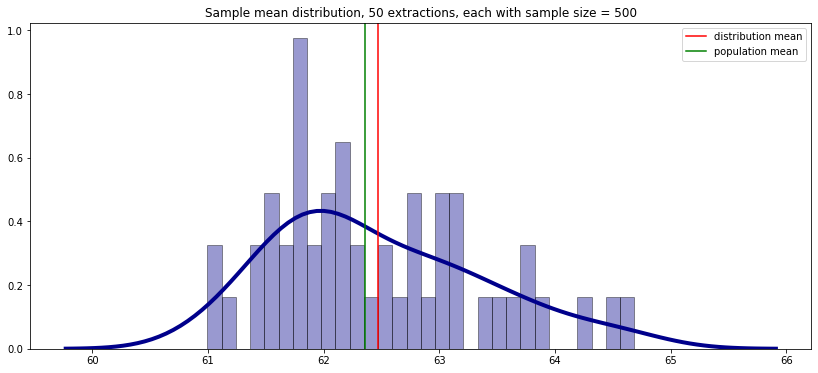

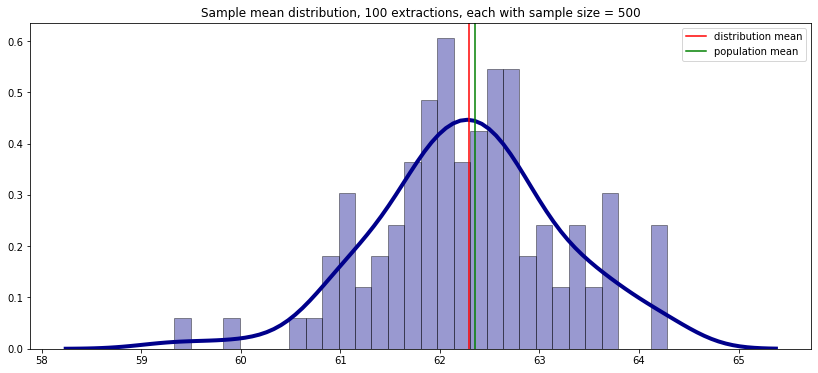

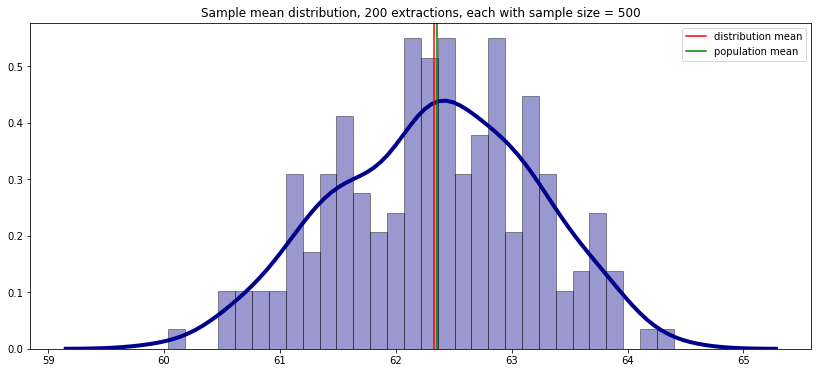

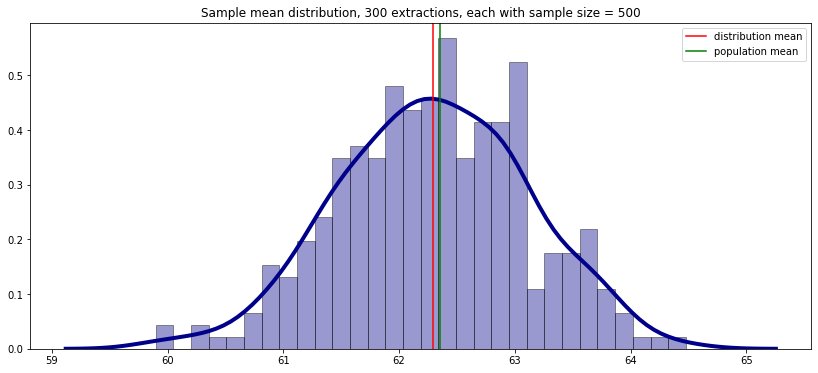

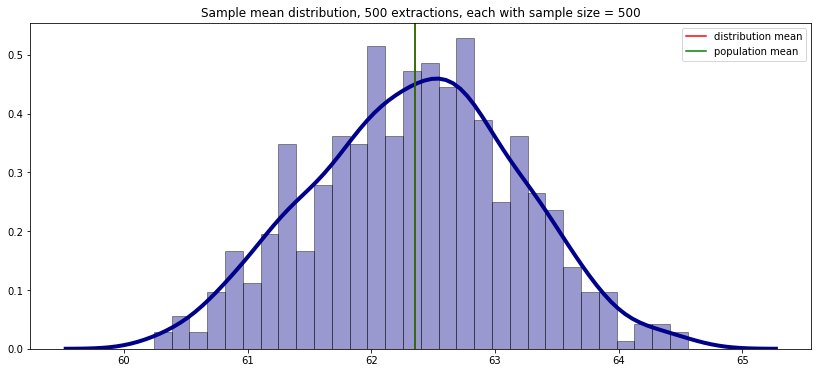

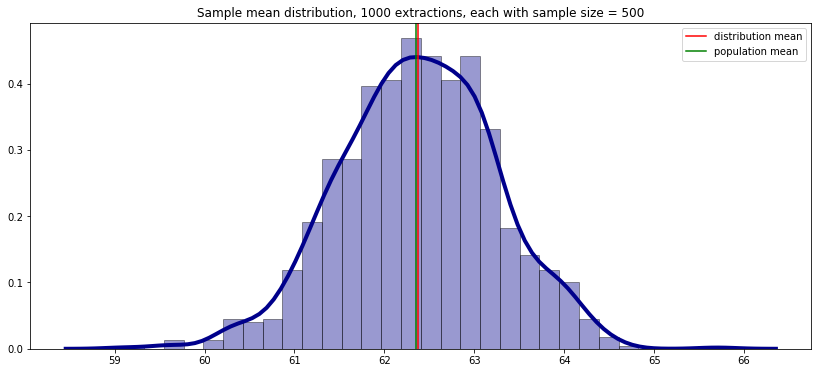

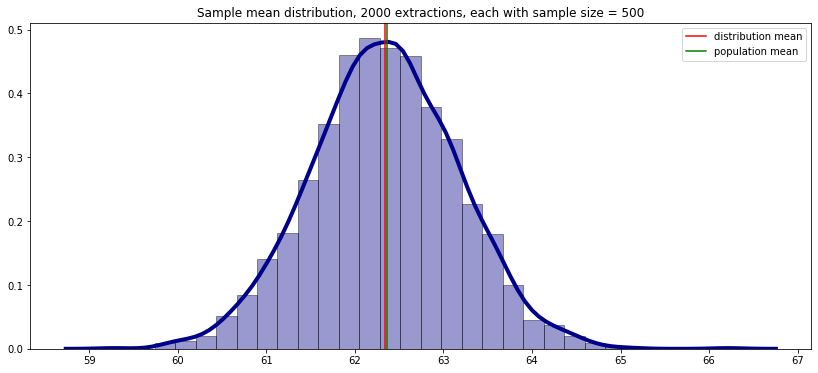

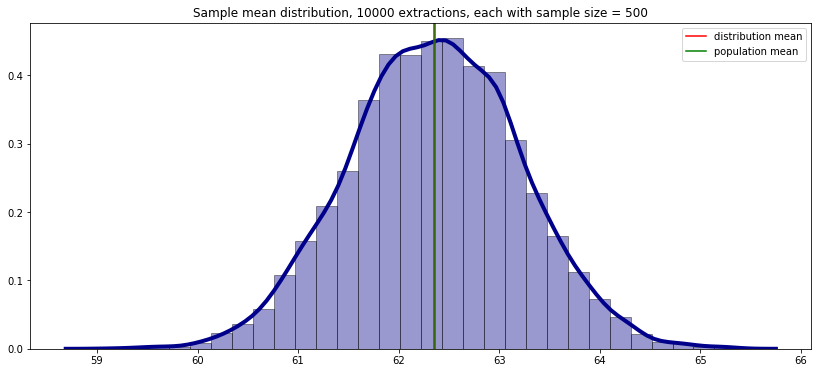

In [6]:
for i in [50,100,200,300,500,1000, 2000, 10000]:
    extract_mean(i, sample_size=500, col_name="Temperature(F)", plot=True)

In [7]:
def plot_mean_std(iterations, confidence=0.95):
    means = {}
    std_devs = {}
    conf_int_width = {}

    for sample_size in [10,20,30,50,100,200,500,1000, 2000, 5000, 7500, 10000]:
        m, s = extract_mean(iterations, sample_size, "Temperature(F)", plot=False)
        h = s * t.ppf((1 + confidence) / 2, sample_size - 1)
        
        means[sample_size] = m
        std_devs[sample_size] = s
        conf_int_width[sample_size] = h
        
    fig, axes = plt.subplots(2,1, figsize=(16,12))

    axes[0].bar([str(el) for el in means.keys()], means.values(), edgecolor="black", 
           yerr=list(conf_int_width.values()), capsize=6)
    
    axes[0].set_ylim((np.min(list(means.values()))-0.5,np.max(list(means.values()))+0.5))

    axes[0].axhline(df["Temperature(F)"].mean(), color="red")

    axes[0].set_xlabel("sample size")
    axes[0].set_ylabel("sample mean")
    axes[0].set_title(f"Mean of sample distribution ({iterations} trials for each sample size)")
    
    axes[1].bar([str(el) for el in std_devs.keys()], std_devs.values(), 
                edgecolor="black", color="orange")
    
    axes[1].set_ylim((np.min(list(std_devs.values()))-0.5,np.max(list(std_devs.values()))+0.5))

    axes[1].axhline(df["Temperature(F)"].std()/np.sqrt(10000), color="red")

    axes[1].set_xlabel("sample size")
    axes[1].set_ylabel("sample standard deviation")
    axes[1].set_title(f"Standard deviation of sample distribution ({iterations}"
                      " trials for each sample size)")
    plt.show()

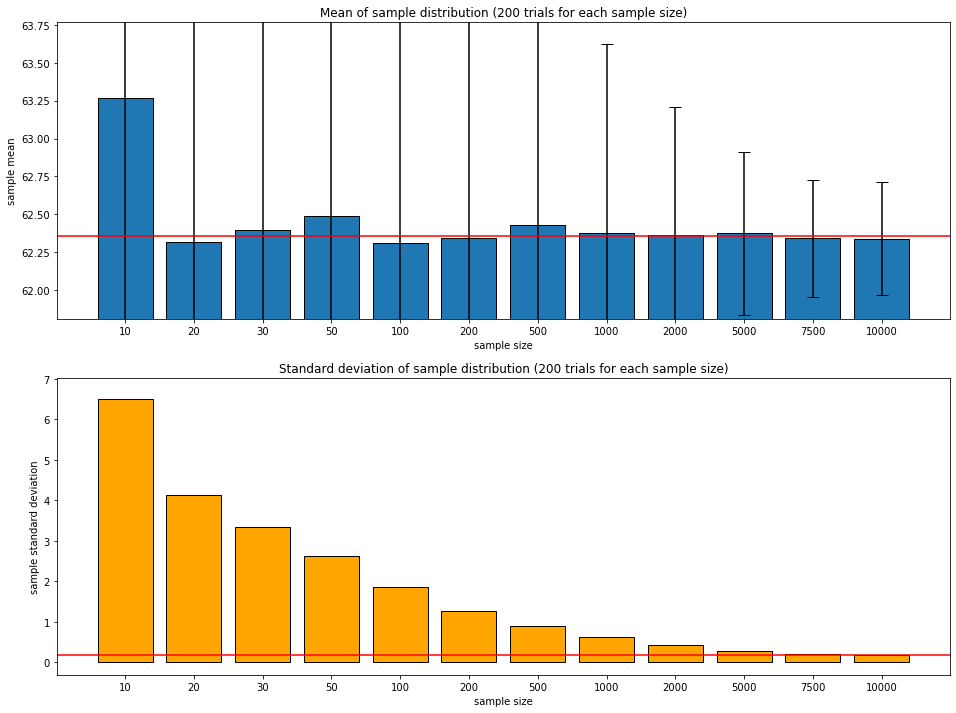

In [28]:
plot_mean_std(200, confidence=0.95)

In [9]:
def plot_mean_fixed(iterations, sample_size, confidence=0.95, plot=False):
    
    true_mean = df["Temperature(F)"].mean()
    true_std = df["Temperature(F)"].std()
    means = []
    std_devs = []
    conf_int_width = [] #actually it is width/2
       
    for i in range(iterations):     
        sample = df["Temperature(F)"] .sample(sample_size, replace=False)  
        h = (true_std/np.sqrt(sample_size)) * t.ppf((1-confidence) / 2, sample_size - 1)
        
        means.append(sample.mean())
        conf_int_width.append(h)
    
    condition = (np.array(np.array(means)-np.array(conf_int_width)<= true_mean)) | \
                (np.array(true_mean <= np.array(means)+np.array(conf_int_width)))
    
    print("wrong: ", np.sum(condition))
    print("wrong percentage: ", np.sum(condition)/iterations)
        
    if plot == True:
        fig, ax = plt.subplots(1,1, figsize=(14,14))
        
        color = ["salmon" if condition[i] else "lightblue" for i in range(len(means)) ]

        ax.barh([str(i) for i in range(len(means))], means, edgecolor="black", 
               xerr=conf_int_width, color=color, capsize=6)

        ax.set_xlim((np.min(means)-0.2,np.max(means)+0.2))

        ax.axvline(true_mean, color="navy", linewidth=2)

        ax.set_xlabel("sample mean")
        ax.set_ylabel("trial number")
        ax.set_title(f"Mean of sample distribution (sample size = {sample_size}")

        plt.show()
    
    return means,std_devs, conf_int_width

wrong:  7
wrong percentage:  0.1


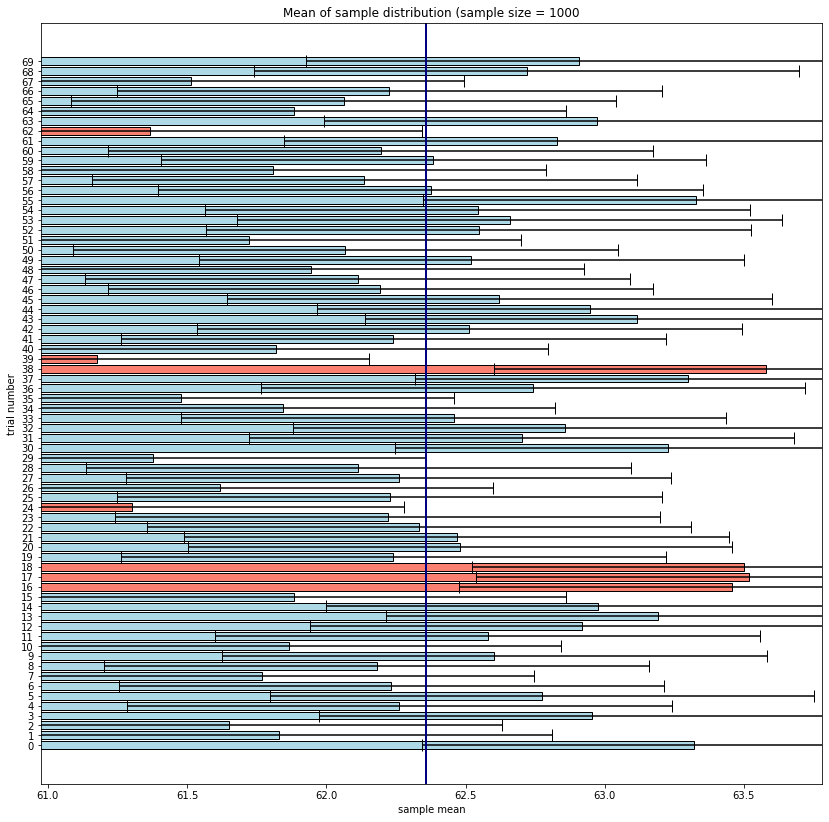

In [27]:
m,s,c = plot_mean_fixed(iterations=70, sample_size=1000, confidence=0.9, plot=True)